# This kernel refered to [This tutorial](https://www.tensorflow.org/tutorials/keras/regression) on regression to solve this problem

In [1]:
!pip install tensorflow==2.1.0 h2o4gpu

In [0]:
import h2o4gpu as sklearn
import tensorflow as tf
import numpy as np
import pandas as pd 
import tensorflow.keras as keras

tf.config.list_physical_devices('GPU')

from tensorflow.keras import Sequential, layers, callbacks, utils
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import DenseFeatures, Dense, Dropout, SpatialDropout1D, BatchNormalization, Concatenate
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow import feature_column

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn import metrics, preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [0]:
#Pass only X 
def norm(data, y, test_size = 0.20):

    stats = data.describe()
    stats.pop(y)
    stats = stats.transpose()
    # print(stats)

    train_dataset = data.sample(frac=0.8,random_state=42)
    test_dataset = data.drop(train_dataset.index)

    train_dataset = train_dataset.reset_index(drop=True)
    test_dataset = test_dataset.reset_index(drop=True)

    train_labels = train_dataset.pop(y)
    test_labels = test_dataset.pop(y)


    normalized_train = (train_dataset - stats['mean']) / stats['std']
    normalized_test  = (test_dataset - stats['mean']) / stats['std']

    return normalized_train, normalized_test, train_labels, test_labels

In [3]:
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/PUBG/processed_data_pubg.csv')
data.head()

,Unnamed: 0,solo_TimeSurvived,solo_RoundsPlayed,solo_Top10Ratio,solo_Losses,solo_MoveDistancePg,solo_TimeSurvivedPg,solo_Top10sPg,solo_Boosts,target_solo_Wins
0,0,18469.14,17,23.5,14,3321.28,1086.42,0.24,29,3
1,1,33014.86,33,33.3,27,5021.41,1000.45,0.33,88,6
2,2,4330.44,5,20.0,5,2804.80,866.09,0.20,3,0
3,3,13421.82,8,75.0,4,5986.82,1677.73,0.75,24,4
4,4,9841.04,6,83.3,4,6526.96,1640.17,0.83,21,2


In [4]:
data = data.drop('Unnamed: 0', 1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87898 entries, 0 to 87897
Data columns (total 9 columns):
solo_TimeSurvived      87898 non-null float64
solo_RoundsPlayed      87898 non-null int64
solo_Top10Ratio        87898 non-null float64
solo_Losses            87898 non-null int64
solo_MoveDistancePg    87898 non-null float64
solo_TimeSurvivedPg    87898 non-null float64
solo_Top10sPg          87898 non-null float64
solo_Boosts            87898 non-null int64
target_solo_Wins       87898 non-null int64
dtypes: float64(5), int64(4)
memory usage: 6.0 MB


In [5]:
data.head()

,solo_TimeSurvived,solo_RoundsPlayed,solo_Top10Ratio,solo_Losses,solo_MoveDistancePg,solo_TimeSurvivedPg,solo_Top10sPg,solo_Boosts,target_solo_Wins
0,18469.14,17,23.5,14,3321.28,1086.42,0.24,29,3
1,33014.86,33,33.3,27,5021.41,1000.45,0.33,88,6
2,4330.44,5,20.0,5,2804.80,866.09,0.20,3,0
3,13421.82,8,75.0,4,5986.82,1677.73,0.75,24,4
4,9841.04,6,83.3,4,6526.96,1640.17,0.83,21,2


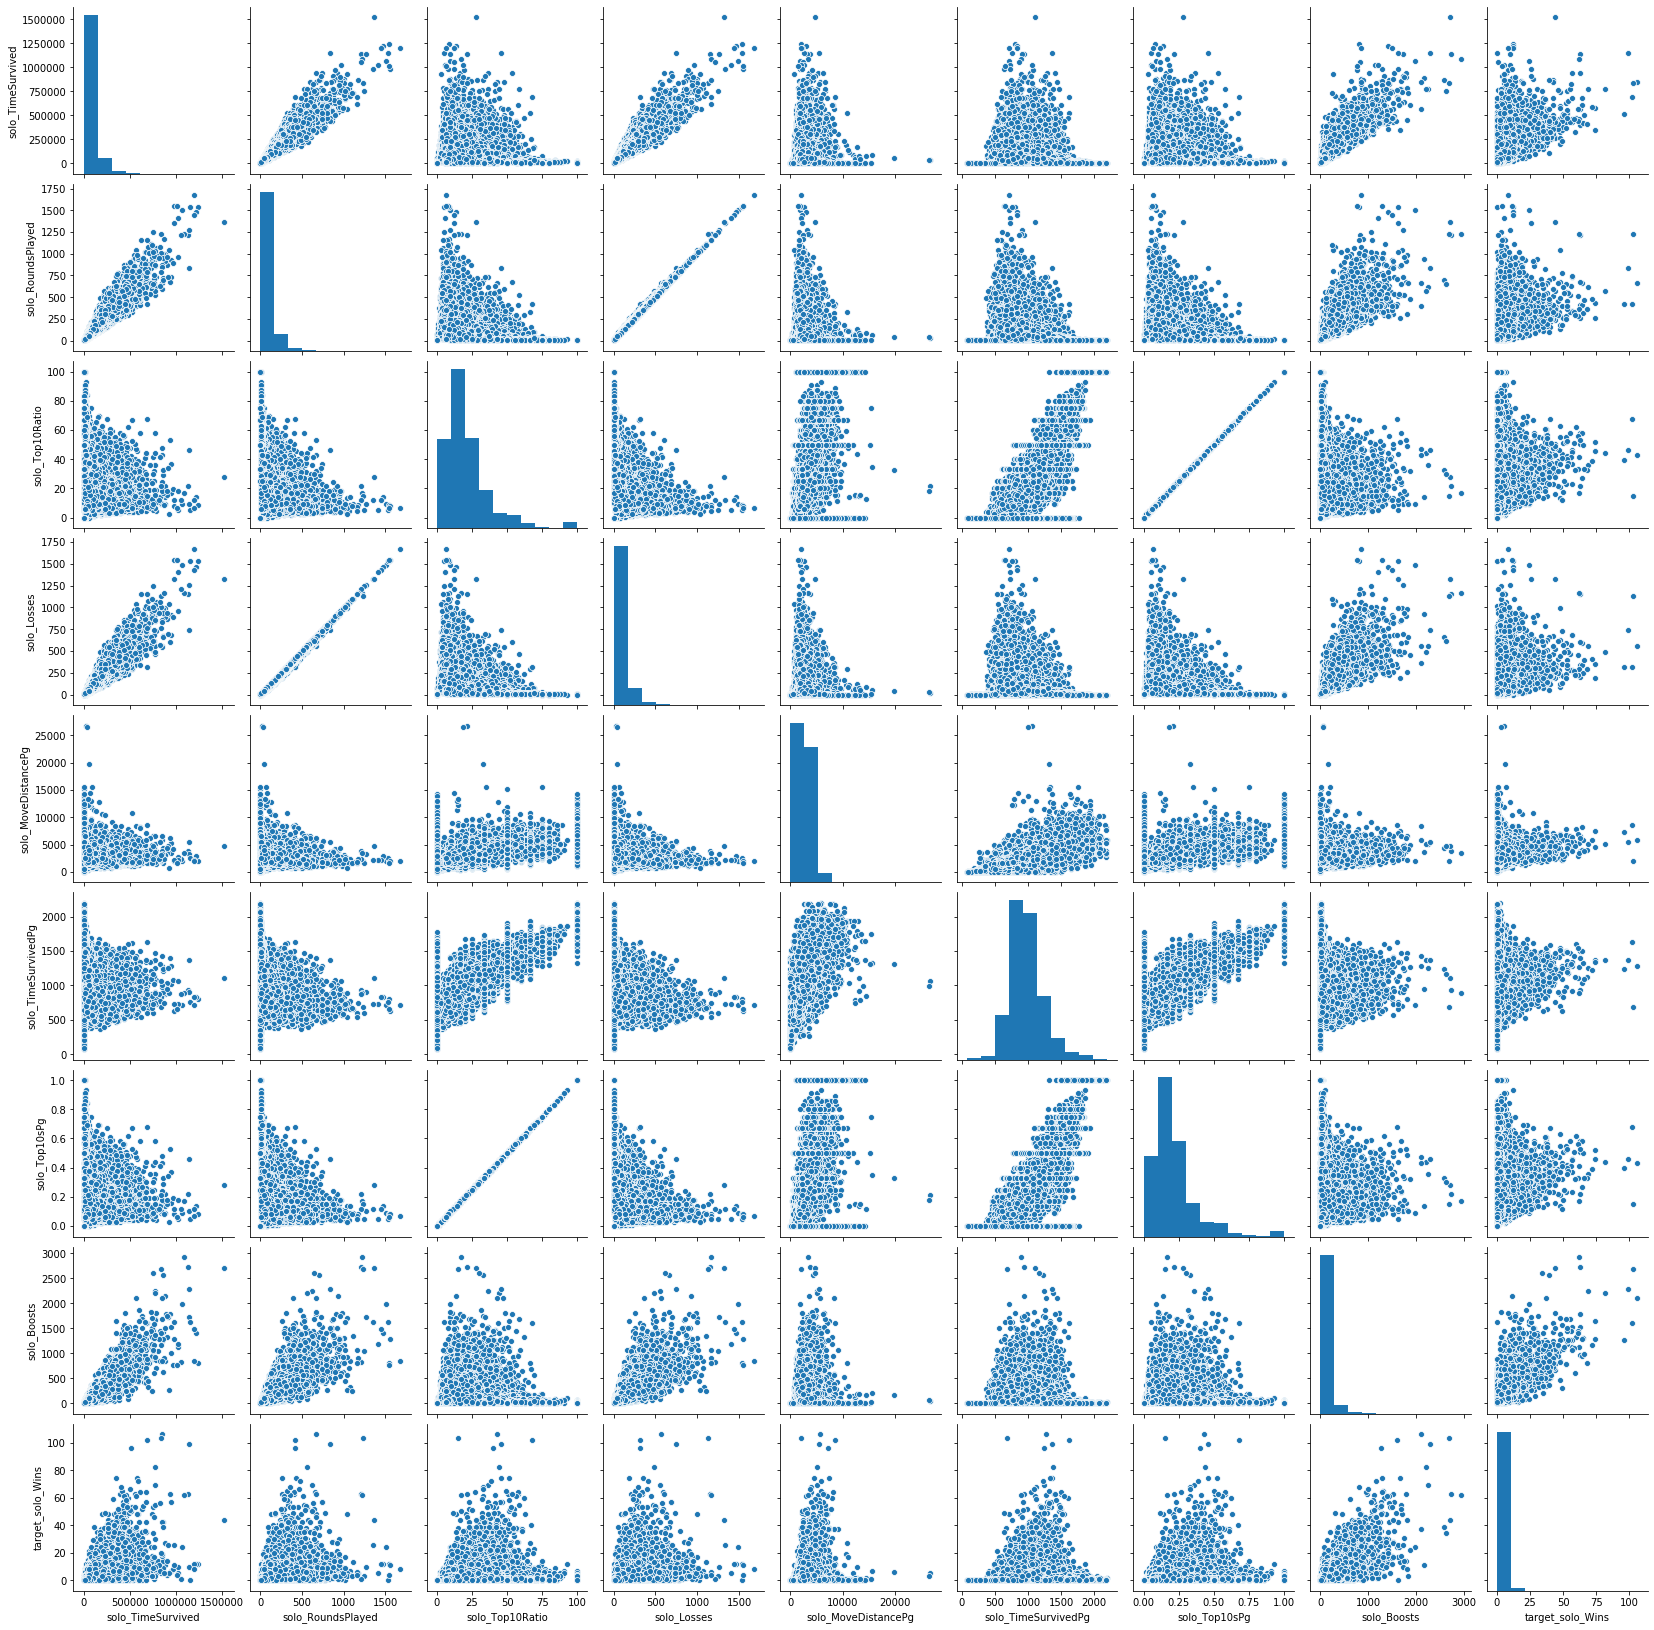

In [6]:
import seaborn as sns
sns.pairplot(data)

In [0]:
normalized_train, normalized_test, train_labels, test_labels = norm(data, y = 'target_solo_Wins')

In [0]:
def build_model_ADAM():
  model = keras.Sequential([
    layers.Dense(1024, activation='relu', input_shape=[len(normalized_train.keys())]),
    # layers.Dense(1024, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation = 'relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  
  model.compile(loss=tf.losses.mean_absolute_error,
                optimizer=tf.optimizers.Adam(),
                metrics=['mse']) #mae is being used as loss function, so for knowing mae refer to loss of the model. loss = mae.
  return model

In [9]:
model2 = build_model_ADAM()
model2.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              9216      
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 829,569
Trainable params: 829,569
Non-trainable params: 0
_________________________________________________________________


In [11]:
EPOCHS = 140

rlr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                  patience=5, min_lr=1e-6, mode='max', verbose=1)

history2 = model2.fit(
  normalized_train, train_labels,
  epochs=EPOCHS, validation_split = 0.1, verbose=1,
  callbacks=[rlr])

Train on 63286 samples, validate on 7032 samples
Epoch 1/140
63286/63286 [==============================] - 24s 372us/sample - loss: 0.3986 - mse: 0.6008 - val_loss: 0.2333 - val_mse: 0.3243
Epoch 2/140
63286/63286 [==============================] - 23s 366us/sample - loss: 0.3157 - mse: 0.3948 - val_loss: 0.3688 - val_mse: 0.5097
Epoch 3/140
63286/63286 [==============================] - 23s 370us/sample - loss: 0.3074 - mse: 0.3791 - val_loss: 0.2089 - val_mse: 0.2238
Epoch 4/140
63286/63286 [==============================] - 23s 371us/sample - loss: 0.2975 - mse: 0.3753 - val_loss: 0.2449 - val_mse: 0.2196
Epoch 5/140
63286/63286 [==============================] - 24s 378us/sample - loss: 0.3036 - mse: 0.3644 - val_loss: 0.2884 - val_mse: 0.3566
Epoch 6/140
63286/63286 [==============================] - 24s 376us/sample - loss: 0.2849 - mse: 0.3268 - val_loss: 0.8079 - val_mse: 1.6815
Epoch 7/140
63286/63286 [==============================] - 24s 376us/sample - loss: 0.2423 - mse: 0

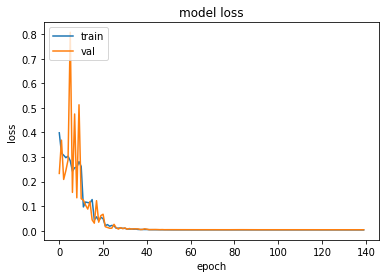

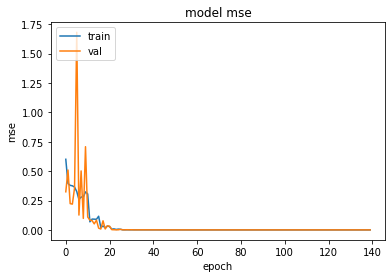

In [13]:
import matplotlib.pyplot as plt

# plt.plot(history2.history['mae'])
# plt.plot(history2.history['val_mae'])
# plt.title('model mae')
# plt.ylabel('mae')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()
# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history2.history['mse'])
plt.plot(history2.history['val_mse'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [14]:
model2.evaluate(x = normalized_test,
                y = test_labels)

17580/17580 [==============================] - 2s 89us/sample - loss: 0.0039 - mse: 1.9241e-04


[0.00385322701046879, 0.00019240589]